In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
%load_ext autoreload
%autoreload 1

%aimport semiparametric, nonparametric, alpha, utils, dataset

from semiparametric import SemiparametricRegressionMP
from nonparametric import NonparametricRegressionMP
from alpha import Alpha, GaussianCopulaD, true_alpha_update

from utils import phi, Phi, timer
from dataset import LIDAR, SyntheticDataset

In [3]:
# lidar_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath("main.ipynb"))), "datasets/lidar.csv")
# 
# data = LIDAR(path=lidar_path)

data_n = 500
data = SyntheticDataset(mean=(0, 1), variance=(0.001, 0.04), skewness=(0, 2), 
                        mean_shape=("sine", {"freq":-np.pi}), variance_shape=("poly", {"degree":2}), skewness_shape=("sine", {"freq":np.pi}))
data.sample(n=data_n)

Text(0, 0.5, 'y')

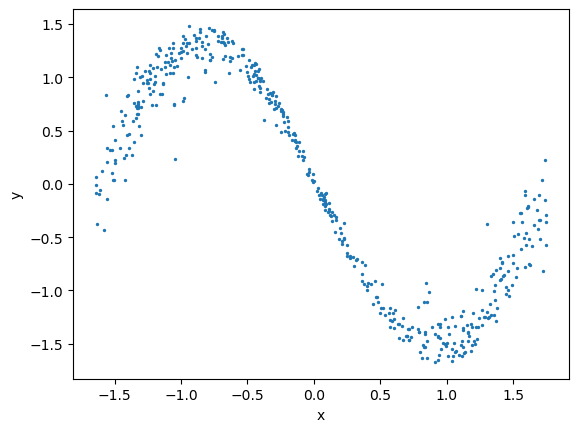

In [4]:
plt.scatter(x=data.x, y=data.y, s=2)
plt.xlabel("x")
plt.ylabel("y")

## Nonparametric

In [5]:
alpha = Alpha(alpha=2, d=GaussianCopulaD(rho=0.93), alpha_updater=true_alpha_update)
rho = 0.8

p0 = lambda x, y: phi(y)
P0 = lambda x, y: Phi(y)

In [6]:
nx, ny = 100, 300
ypad = 1
x_linspace = np.linspace(data.x.min(), data.x.max(), nx)
y_linepsace = np.linspace(data.y.min()-ypad, data.y.max()+ypad, ny)

dy = y_linepsace[1] - y_linepsace[0]

x_test, y_test = np.meshgrid(x_linspace, y_linepsace)

Ey_generator = lambda ps: (lambda gy: np.sum(ps * dy * gy, axis=0))

In [7]:
perm_n = 10
nmps = []
nmp_Ps = np.zeros((perm_n, ny, nx))
nmp_ps = np.zeros((perm_n, ny, nx))

sim_n = len(data)

In [8]:
def nonparametric(i):
    data.shuffle()
    nmps.append(NonparametricRegressionMP(p0=p0, P0=P0, rho=rho, alpha=alpha))
    nmps[i].train(data.x, data.y)
    _nmp_P, _nmp_p = nmps[i].get(x_test.flatten(), y_test.flatten(), n=sim_n)
    nmp_Ps[i] = _nmp_P[-1].reshape(ny, nx)
    nmp_ps[i] = _nmp_p[-1].reshape(ny, nx)

In [9]:
timer(nonparametric, perm_n=perm_n)

100%|██████████| 10/10 [00:33<00:00,  3.34s/it]

Total Time: 33.3755 seconds, 3.3375 seconds per iter.


In [10]:
nmp_p = nmp_ps.mean(axis=0)
nmp_P = nmp_Ps.mean(axis=0)

Ey = Ey_generator(nmp_p)

In [11]:
nmp_mean = Ey(y_test)
nmp_var = Ey((y_test - nmp_mean)**2)
nmp_std = np.sqrt(nmp_var)
nmp_skew = Ey(((y_test - nmp_mean)/nmp_std)**3)

nmp_p025 = np.zeros((nx,))
nmp_p975 = np.zeros((nx,))
for j in range(nx):
    nmp_p025[j] = y_linepsace[np.searchsorted(nmp_P[:, j], 0.025)-1]
    nmp_p975[j] = y_linepsace[np.searchsorted(nmp_P[:, j], 0.975)-1]

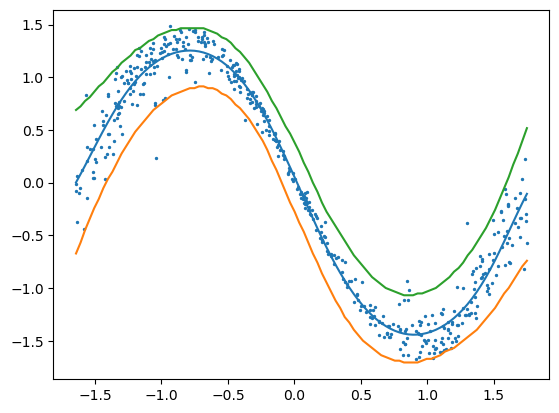

In [12]:
## Theres some bugs here
plt.scatter(x=data.x, y=data.y, s=2)

plt.plot(x_linspace, nmp_mean)
plt.plot(x_linspace, nmp_p025)
plt.plot(x_linspace, nmp_p975)

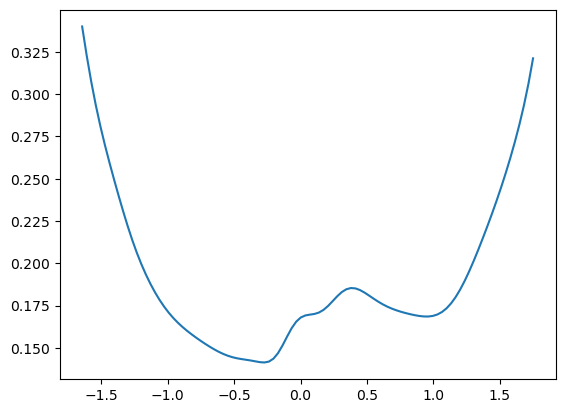

In [13]:
plt.plot(x_linspace, nmp_std)

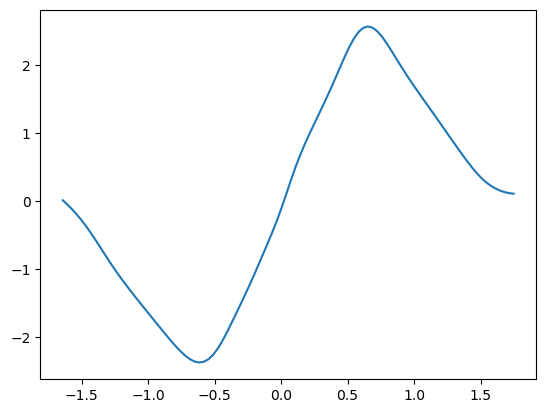

In [14]:
plt.plot(x_linspace, nmp_skew)

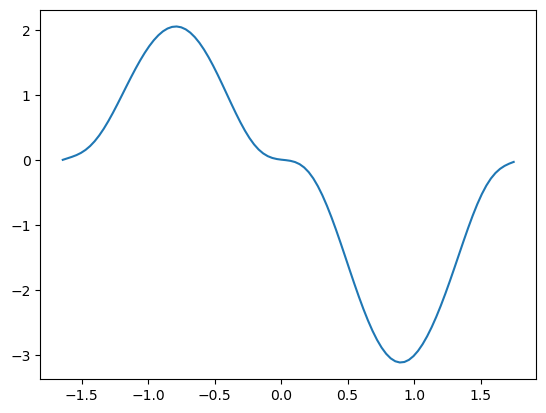

In [15]:
plt.plot(x_linspace, Ey(y_test**3))

## Semiparametric

In [16]:
data.reset_rng()

In [17]:
alpha = Alpha(alpha=2, d=GaussianCopulaD(rho=0.93), alpha_updater=true_alpha_update)
rho = 0.8

def moment_init(x):
    return np.array([
        np.zeros(x.shape),
        np.ones(x.shape),
        np.zeros(x.shape)
    ])

n_moments = len(moment_init(np.zeros(1)))

In [18]:
nx = 100

x_linspace = np.linspace(data.x.min(), data.x.max(), nx)

In [19]:
perm_n = 10
smps = []
smp_mus = np.zeros((perm_n, nx))
smp_sigmas = np.zeros((perm_n, nx))
smp_sigma2s = np.zeros((perm_n, nx))
smp_moments = np.zeros((perm_n, n_moments, nx))

sim_n = len(data)

In [20]:
def semiparametric(i):
    data.shuffle()
    smps.append(SemiparametricRegressionMP(ms_0=moment_init, n_moments=n_moments, rho=rho, alpha=alpha))
    #smps[i].set_update(smps[i]._old_update)
    smps[i].train(data.x, data.y)
    _result = smps[i].get(x_linspace, n=sim_n)
    _mu, _sigma, _sigma2, _moment = _result.values()
    smp_mus[i], smp_sigmas[i], smp_sigma2s[i], smp_moments[i] = _mu[-1], _sigma[-1], _sigma2[-1], _moment[:, -1]

In [21]:
timer(semiparametric, perm_n=perm_n)

100%|██████████| 10/10 [00:00<00:00, 21.01it/s]

Total Time: 0.4777 seconds, 0.0478 seconds per iter.


In [22]:
smp_mu = smp_mus.mean(axis=0)
smp_moment = smp_moments.mean(axis=0)

smp_sigma2 = smp_moment[1] - smp_moment[0]**2
smp_sigma = np.sqrt(smp_sigma2)
smp_skew = (smp_moment[2] - 3*smp_moment[1]*smp_moment[0] + 2*smp_moment[0]**3)/smp_sigma**3

Text(0, 0.5, 'y')

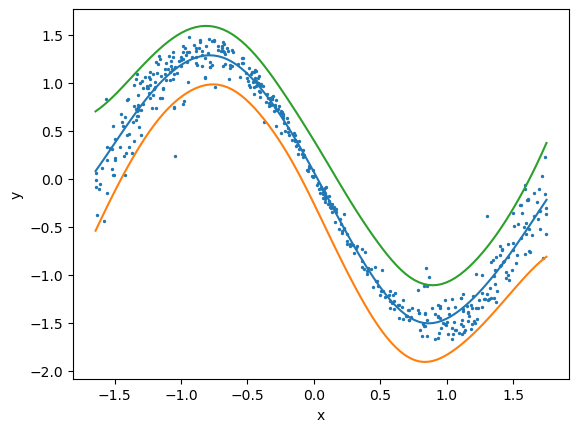

In [23]:
plt.scatter(x=data.x, y=data.y, s=2)

plt.plot(x_linspace, smp_mu)
plt.plot(x_linspace, smp_mu-smp_sigma*1.96)
plt.plot(x_linspace, smp_mu+smp_sigma*1.96)

plt.xlabel("x")
plt.ylabel("y")

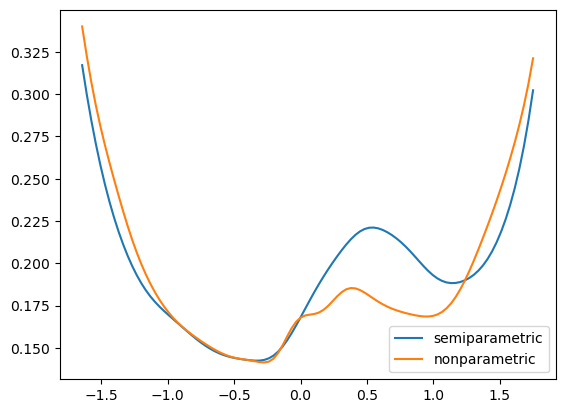

In [24]:
plt.plot(x_linspace, smp_sigma, label="semiparametric")
plt.plot(x_linspace, nmp_std, label="nonparametric")
plt.legend()

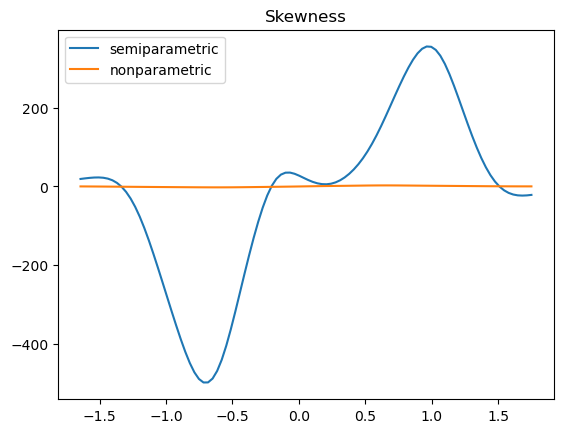

In [25]:
plt.plot(x_linspace, smp_skew, label="semiparametric")
plt.plot(x_linspace, nmp_skew, label="nonparametric")
plt.title("Skewness")
plt.legend()

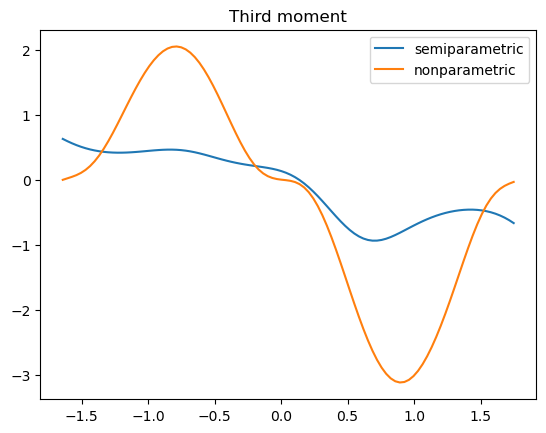

In [26]:
plt.plot(x_linspace, smp_moment[2], label="semiparametric")
plt.plot(x_linspace, Ey(y_test**3), label="nonparametric")
plt.title("Third moment")
plt.legend()